<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Aptos;text-align:center;display:fill;border-radius:5px;background-color:#00008B;overflow:hidden"><b>AI use cases & XAI techniques in Insurance</b></div>

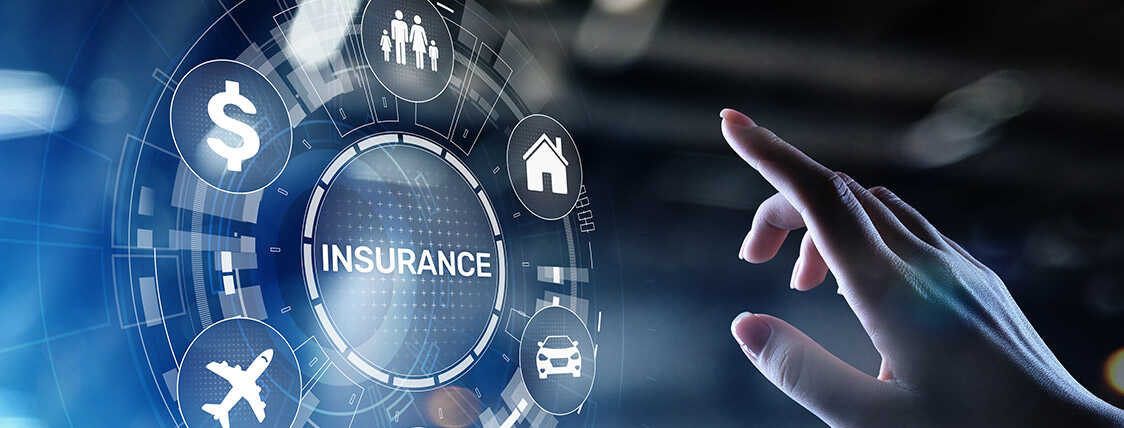

### **1. Initiate libraries and paths**

In [1]:
import PyPDF2
import pandas as pd
import numpy as np
from transformers import pipeline
import os
from glob import glob
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import re

# Folder paths for txt files
abstracts_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Abstracts'
pdf_folder = 'C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature'

c:\Users\bart_\anaconda3\envs\llms\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **2. Create word cloud**

In [20]:
# Load text from all txt files
abstract_texts = []
for file in glob(os.path.join(abstracts_folder, "*.txt")):
    with open(file, 'r', encoding='utf-8') as f:
        abstract_texts.append(f.read())

# Print the number of abstracts read
print(f"Number of abstracts read: {len(abstract_texts)}")

# Join all abstracts into one text for word cloud generation
all_abstracts_text = " ".join(abstract_texts)

Number of abstracts read: 88


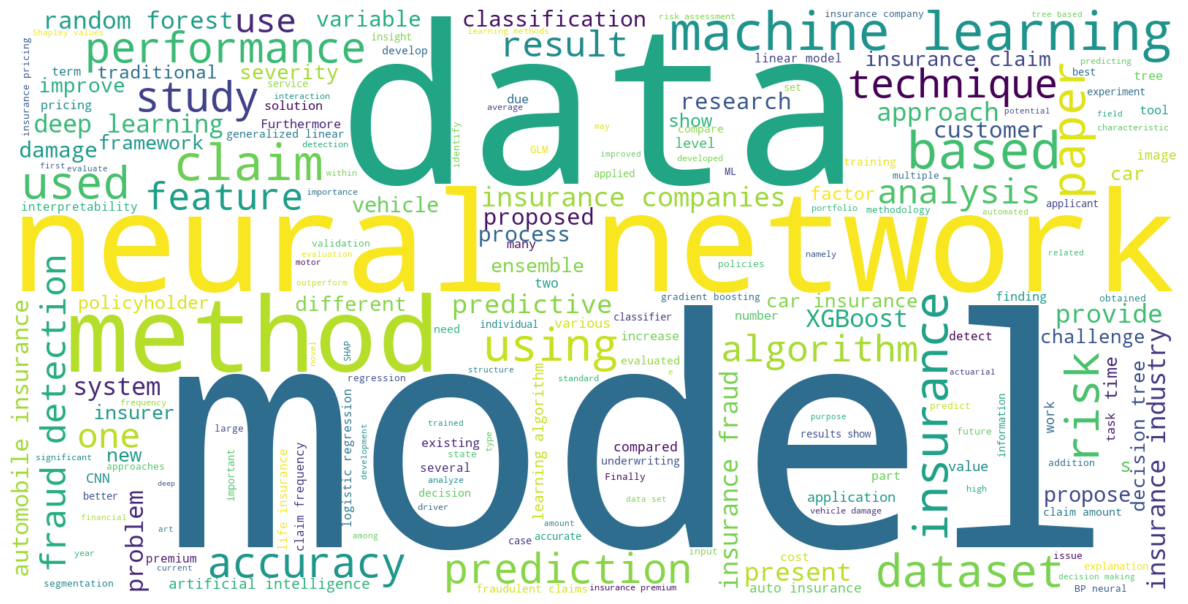

In [21]:
# Generate word cloud
wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(all_abstracts_text)

# Save the word cloud as an image with high resolution
plt.figure(figsize=(11.69, 8.27))  # A4 aspect ratio in inches (landscape orientation)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()

### **3. Word counter on words of interest**

In [2]:
# Initiate empty dict
pdf_texts = {}

# Use glob to find all PDFs in subfolders
for file in glob(os.path.join(pdf_folder, "**", "*.pdf"), recursive=True):
    pdf_text = ""
    with open(file, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            pdf_text += pdf_reader.pages[page_num].extract_text()
    
    # Extract the subfolder name
    subfolder_name = os.path.basename(os.path.dirname(file))

    # Store everything
    pdf_texts[(os.path.basename(file), subfolder_name)] = pdf_text

Invalid parent xref., rebuild xref


In [8]:
# List of insurance-related words
word_dict = pd.read_excel('C:/Users/bart_/Documents/Ethical_AI/Assignment/Taxonomies.xlsx')

In [9]:
word_dict

,Interest_word,Design,Origin,Scope
0,logistic regression,Transparent,Model-Specific,Global
1,linear regression,Transparent,Model-Agnostic,Local
2,k-nearest neighbors,Transparent,NaN,NaN
3,knn,Transparent,NaN,NaN
4,rule-based learner,Transparent,NaN,NaN
5,general additive model,Transparent,NaN,NaN
6,general linear model,Transparent,NaN,NaN
7,decision tree,Transparent,NaN,NaN
8,random forest,Post-hoc explainability,NaN,NaN
9,gradient boosting,Post-hoc explainability,NaN,NaN


In [10]:
interest_words = word_dict['Interest_word'].to_list()
interest_words

['logistic regression',
 'linear regression',
 'k-nearest neighbors',
 'knn',
 'rule-based learner',
 'general additive model',
 'general linear model',
 'decision tree',
 'random forest',
 'gradient boosting',
 'gbm',
 'xgboost',
 'neural network',
 'rnn',
 'cnn',
 'ensemble learning',
 'support vector machines',
 'svm',
 'genetic algorithm',
 'explainable ai',
 'explainable artificial intelligence',
 'xai',
 'lime',
 'shapley',
 'shap',
 'partial dependence plots',
 'pdp',
 'feature importance',
 'surrogate',
 'variable importance',
 'ice']

In [11]:
pdf_word_counts = []

for (filename, subfolder), text in pdf_texts.items():
    # Remove the '.pdf' extension
    title = filename.replace('.pdf', '')

    # Extract the publication year (last 4 characters)
    publication_year = None
    if len(title) >= 4 and title[-4:].isdigit():
        publication_year = int(title[-4:])
        # Remove the publication year from the title
        title = title[:-4].strip()

    # Convert text to lowercase
    text_lower = text.lower()
    count_data = {
        'title': title,
        'subdomain': subfolder,
        'publication_year': publication_year}
    
    # Count function
    for term in interest_words:
        if " " in term:  
            count = len(re.findall(r'\b' + re.escape(term) + r'\b', text_lower))
        else:  
            count = text_lower.split().count(term)
        
        count_data[term] = count
    
    pdf_word_counts.append(count_data)

df = pd.DataFrame(pdf_word_counts)

In [12]:
XAI_techniques = word_dict[word_dict['Design'] == 'XAI_technique']['Interest_word'].to_list()

df['XAI_used?'] = np.where(df[XAI_techniques].sum(axis=1) > 2,1,0)

In [2]:
#Optional: load the reviewed df
df = pd.read_excel('C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature_review.xlsx', sheet_name='chk_word_counts')
df_xai_taxonomy = pd.read_excel('C:/Users/bart_/Documents/Ethical_AI/Assignment/Literature_review.xlsx', sheet_name='taxonomy')

In [3]:
df

,Unnamed: 0,title,subdomain,code,publication_year,logistic regression,linear regression,k-nearest neighbors,knn,rule-based learner,...,attention,feature importance,surrogate,variable importance,ice,XAI_used?,Notes,Data type,LoB,XAI technique
0,0,A Deep Learning and Transfer Learning Approach...,Claims_handling,claims1,2021,0,0,0,0,0,...,0.0,0,0,0,0,0,Deep learning and transfer learning approach f...,image data,auto,NaN
1,1,Automated Car Damage Assessment Using Computer...,Claims_handling,claims2,2024,0,0,0,0,0,...,0.0,1,0,0,0,1,"Here, an ensemble of multiple neural network m...",image data,auto,NaN
2,2,Automated Detection of Multi-class Vehicle Ext...,Claims_handling,claims3,2021,0,0,0,0,0,...,0.0,0,0,0,0,0,Vehicle damage detection with CNN. No XAI used.,image data,auto,NaN
3,3,Automated vehicle damage classification,Claims_handling,claims4,2024,0,0,0,0,0,...,0.0,0,0,0,0,0,Vehicle damage detection with CNN. No XAI used.,image data,auto,NaN
4,4,Automatic damaged vehicle estimator using enha...,Claims_handling,claims5,2023,0,0,0,0,0,...,0.0,1,0,0,0,1,Vehicle damage detection with CNN. Visualizati...,image data,auto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,66,Using contextual data to predict risky driving...,Risk_assessment,risk24,2023,0,0,0,0,0,...,0.0,1,0,0,0,1,Use telematics data with contextual risk facto...,Tabular,auto,NaN
67,67,Automated Underwriting in Life Insurance Predi...,Underwriting,underwriting1,2018,1,0,0,0,0,...,0.0,1,0,0,0,1,Underwriting in life insurance is investigated...,tabular,life,Feature relevance explanation
68,68,Improving the Accuracy and Transparency of Und...,Underwriting,underwriting2,2020,0,0,0,0,0,...,0.0,1,0,0,0,1,Used a random survival forest. There is explan...,tabular,life,Feature relevance explanation
69,69,Risk prediction in life insurance industry usi...,Underwriting,underwriting3,2018,0,0,0,0,0,...,0.0,0,0,0,0,0,Risk prediction for underwriting in life insur...,tabular,life,NaN


In [14]:
df['XAI_used?'].sum()

29

In [15]:
#df.to_csv('C:/Users/bart_/Documents/Ethical_AI/Assignment/chk_word_counts.csv')

### **4. Visualizations**

**4.1 References per publication year**

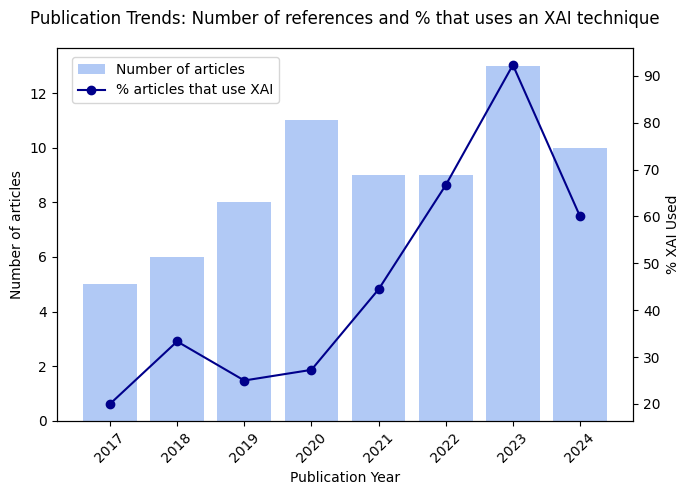

In [3]:
# Create the grouped view
grouped = df.groupby('publication_year').agg(title_count=('title', 'count'),xai_sum=('XAI_used?', 'sum')).reset_index()
grouped['xai_percentage'] = (grouped['xai_sum'] / grouped['title_count']) * 100

# Plot area
fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for count of articles
ax1.bar(grouped['publication_year'], grouped['title_count'], color='cornflowerblue', label='Number of articles', alpha=0.5)
ax1.set_xlabel('Publication Year')
ax1.set_ylabel('Number of articles', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(grouped['publication_year'])
ax1.set_xticklabels(grouped['publication_year'].astype(int), rotation=45)

# Line plot for XAI usage
ax2 = ax1.twinx()
ax2.plot(grouped['publication_year'], grouped['xai_percentage'], color='darkblue', marker='o', label='% articles that use XAI')
ax2.set_ylabel('% XAI Used', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Figure settings
ax1.grid(False)
ax2.grid(False)
fig.suptitle('Publication Trends: Number of references and % that uses an XAI technique')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

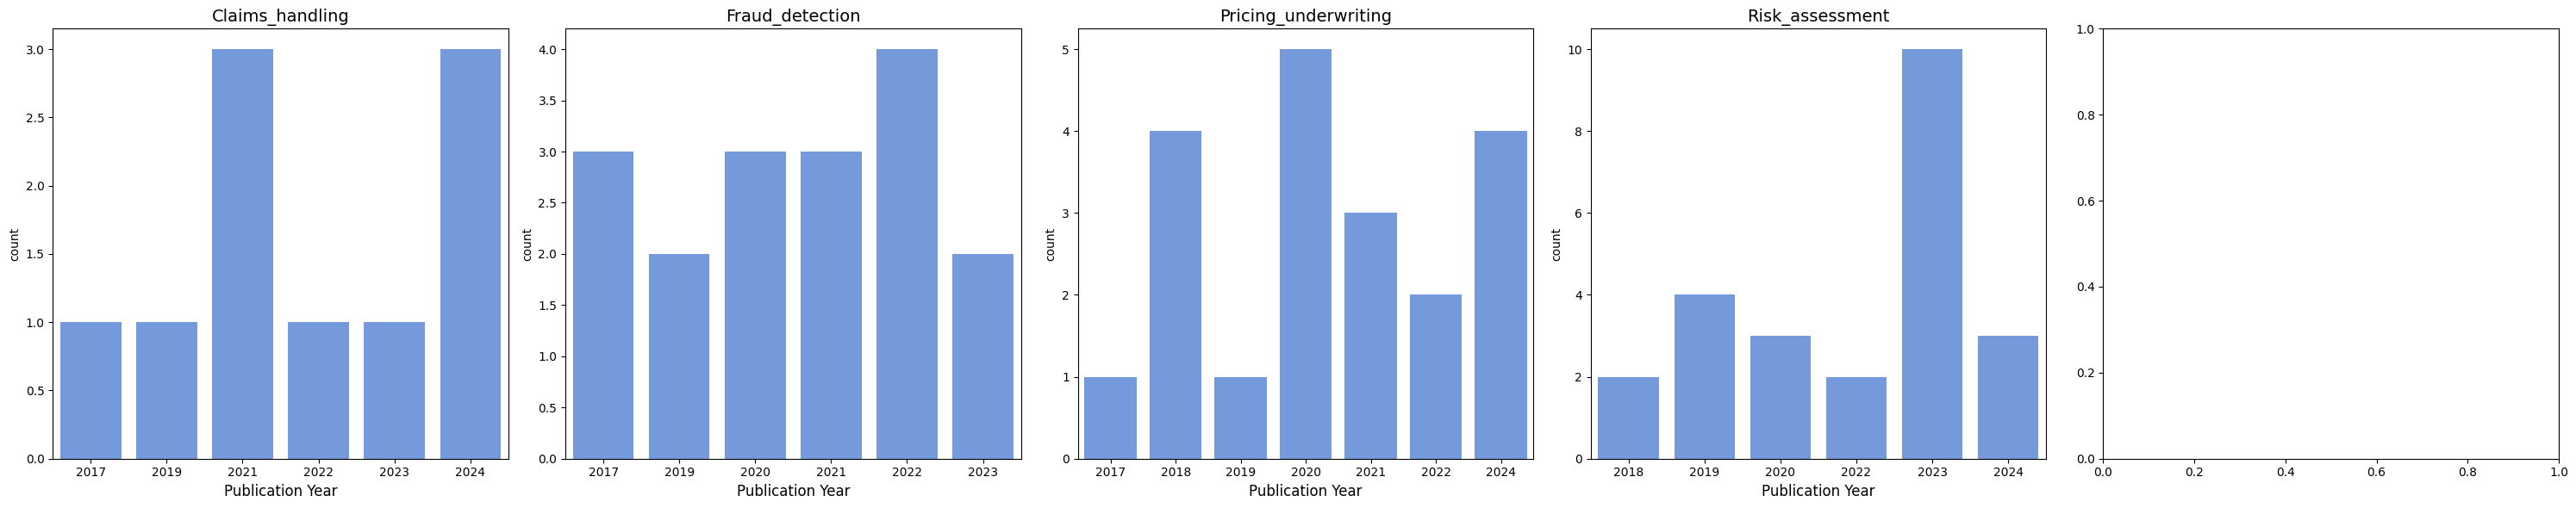

In [4]:
# Get unique subfolders
subdomains = df['subdomain'].unique()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 6),sharex=False, sharey=False)

# Iterate over subfolders and create a count plot for each
for ax, subdomain in zip(axes, subdomains):
    subset = df[df['subdomain'] == subdomain]
    
    sns.countplot(data=subset,x='publication_year',ax=ax,color='cornflowerblue',order=sorted(subset['publication_year'].unique()))
    
    ax.set_title(f'{subdomain}', fontsize=14)
    ax.set_xlabel('Publication Year', fontsize=12)

plt.tight_layout()
plt.show()

**4.2 References per subdomain**

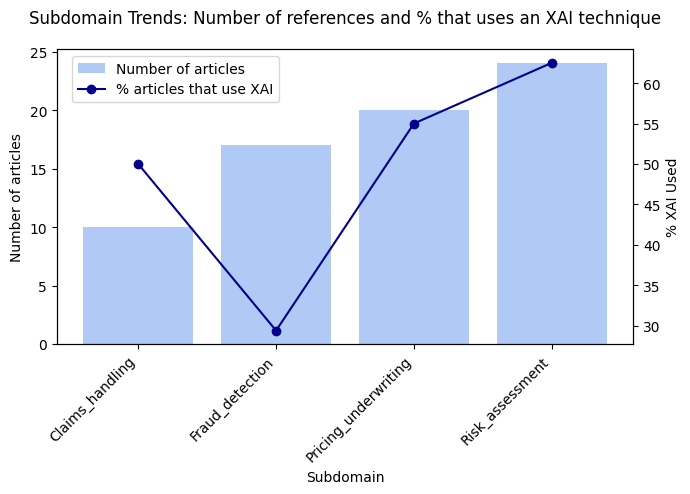

In [5]:
# Create the grouped view
grouped_subdomain = df.groupby('subdomain').agg(title_count=('title', 'count'),xai_sum=('XAI_used?', 'sum')).reset_index()
grouped_subdomain['xai_percentage'] = (grouped_subdomain['xai_sum'] / grouped_subdomain['title_count']) * 100

# Plot area
fig, ax1 = plt.subplots(figsize=(7, 5))

# Bar plot for count of articles
ax1.bar(grouped_subdomain['subdomain'], grouped_subdomain['title_count'], color='cornflowerblue', label='Number of articles', alpha=0.5)
ax1.set_xlabel('Subdomain')
ax1.set_ylabel('Number of articles', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks(grouped_subdomain['subdomain'])
ax1.set_xticklabels(grouped_subdomain['subdomain'], rotation=45, ha='right')

# Line plot for XAI usage
ax2 = ax1.twinx()
ax2.plot(grouped_subdomain['subdomain'], grouped_subdomain['xai_percentage'], color='darkblue', marker='o', label='% articles that use XAI')
ax2.set_ylabel('% XAI Used', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Figure settings
ax1.grid(False)
ax2.grid(False)
fig.suptitle('Subdomain Trends: Number of references and % that uses an XAI technique')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

**4.3 Heatmap of AI and XAI techniques**

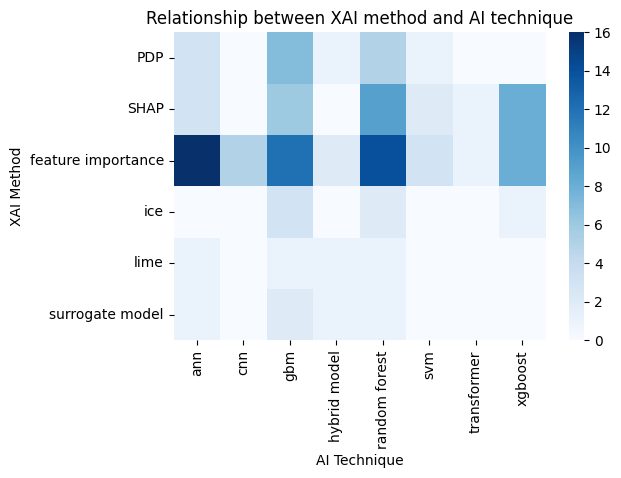

In [19]:
# Define AI and XAI techniques
word_dict = pd.melt(df, id_vars=['title'], var_name='Interest_word', value_name='Count')
word_dict['Design'] = word_dict['Interest_word'].apply(
    lambda x: 'Post-hoc explainability' if x in [
        'random forest', 'xgboost','gbm', 'ann', 'cnn', 'svm', 
        'genetic algorithm', 'reinforcement learning', 'transformer', 'hybrid model'
    ] else ('XAI_technique' if x in [
        'lime', 'shap', 'partial dependence plots',
        'feature importance', 'surrogate model', 'variable importance', 'ice', 'hybrid model'
    ] else 'Other')
)

AI_techniques = word_dict[word_dict['Design'] == 'Post-hoc explainability']['Interest_word'].unique().tolist()
XAI_techniques = word_dict[word_dict['Design'] == 'XAI_technique']['Interest_word'].unique().tolist()

filtered_df = df[['title'] + AI_techniques + XAI_techniques]

# Reshape the df
melted_df = pd.melt(filtered_df, id_vars=['title'], var_name='Technique', value_name='Count')
melted_df = melted_df[melted_df['Count'] > 0]

# Separate AI and XAI techniques
melted_df['Category'] = melted_df['Technique'].apply(lambda x: 'AI' if x in AI_techniques else 'XAI')

# Create AI-XAI combinations
ai_xai_combinations = melted_df.pivot_table(index='title', columns='Category', values='Technique', aggfunc=lambda x: list(x)).dropna()

# Explode to create all combinations of AI and XAI techniques for each title
ai_xai_combinations = ai_xai_combinations.explode('AI').explode('XAI').dropna().reset_index()

# Map similar XAI techniques
xai_mapping = {
    'shapley': 'SHAP',
    'shap': 'SHAP',
    'partial dependence plots': 'PDP',
    'pdp': 'PDP',
    'variable importance':'feature importance'
}
ai_xai_combinations['XAI'] = ai_xai_combinations['XAI'].replace(xai_mapping)

# Counts
heatmap_data = ai_xai_combinations.groupby(['XAI', 'AI']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=False, cmap='Blues', cbar=True, fmt='d')
plt.title('Relationship between XAI method and AI technique')
plt.xlabel('AI Technique')
plt.ylabel('XAI Method')
plt.show()


**4.4 XAI taxonomies**

In [3]:
df_xai_taxonomy

,Subdomain,Feature relevance explanation,Explanation by simplification,Visual explanation,Hybrid approach
0,Claims handling,NaN,NaN,5.0,NaN
1,Fraud detection,4.0,NaN,NaN,NaN
2,Pricing & underwriting,9.0,3.0,5.0,2.0
3,Risk assessment,12.0,1.0,4.0,2.0


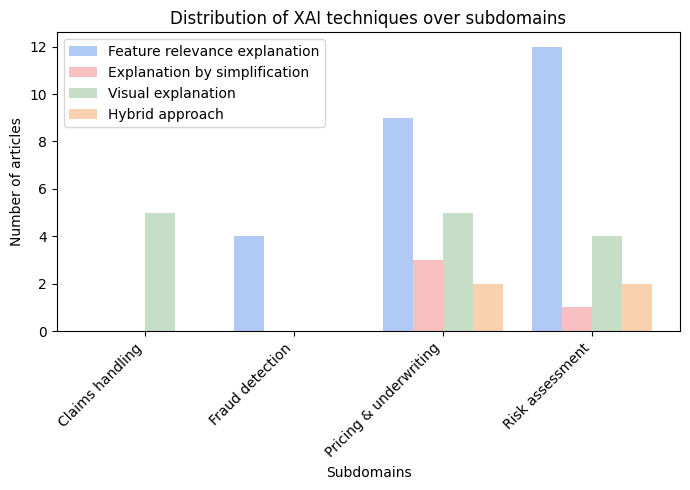

In [9]:
# Replace NaN values
df_filled = df_xai_taxonomy.fillna(0)

# Plot settings
x = np.arange(len(df_filled['Subdomain']))  # the label locations
width = 0.2  # the width of the bars

# Define colors
colors = {
    'Feature relevance explanation': '#6495ED',  # Cornflower Blue#6495ED
    'Explanation by simplification': '#F08080',  # Light Coral
    'Visual explanation': '#8FBC8F',            # Dark Sea Green
    'Hybrid approach': '#F4A460'                # Sandy Brown
}

# Create the plot area
fig, ax = plt.subplots(figsize=(7, 5))

# Plots
rects1 = ax.bar(x - 1.5*width, df_filled['Feature relevance explanation'], width, 
                label='Feature relevance explanation', color=colors['Feature relevance explanation'], alpha=0.5)
rects2 = ax.bar(x - 0.5*width, df_filled['Explanation by simplification'], width, 
                label='Explanation by simplification', color=colors['Explanation by simplification'], alpha=0.5)
rects3 = ax.bar(x + 0.5*width, df_filled['Visual explanation'], width, 
                label='Visual explanation', color=colors['Visual explanation'], alpha=0.5)
rects4 = ax.bar(x + 1.5*width, df_filled['Hybrid approach'], width, 
                label='Hybrid approach', color=colors['Hybrid approach'], alpha=0.5)

# Chart layout
ax.set_xlabel('Subdomains')
ax.set_ylabel('Number of articles')
ax.set_title('Distribution of XAI techniques over subdomains')
ax.set_xticks(x)
ax.set_xticklabels(df_filled['Subdomain'], rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()